In [1]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
PATH_TO_PROJECT = path_to_this_notebook[: path_to_this_notebook.find('notebooks')]
sys.path.append(PATH_TO_PROJECT)
from src.preprocessing.load_data import *
from src.preprocessing.process_softchirp_features import find_outliers, choose_features
from src.data_representations.softchirp_features import compute_all_features
from src.data_representations.process_traces import clear_trace
from src.preprocessing.filters import filter_recs_metadata, filter_sounds_metadata_extended
from src.preprocessing.process_sounds_metadata import extend_sounds_metadata, compute_epochs
from src.visualization.plot_softchirps import plot
from src.util import delete_indexes
import src.visualization.plot_softchirps
from notebooks.analysis.plotting_config import ORDER, COLOR, EPOCHS # change plotting_config file to change colors
from src.data_analysis.softchirps_classification import classify, make_bins
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import defaultdict
import matplotlib
import matplotlib.cm as cm
%matplotlib inline

def load_traces_wavs_and_metadata(recs_metadata, info=None, recs_dict = None, filter_wavs=True,
                                  sr=22050):
    """ Loads traces and sounds for recordings in recs metadata. 
        If recording_dict is provided (dict{rec_name : rec_wav}) recordings will taken from it,
        otherwise, the rec_dict will be loaded"""
    traces, wavs, sounds_metadata,  = [], [], []
    if recs_dict is None:
        recs_dict = load_recs_dict(recs_metadata)
        
    for (rec_name, rec_path, colony, 
         date, ratids, exp) in recs_metadata[['name', 'path', 'colony', 'date', 'ratids', 'experiment']].values:

        path_to_traces = rec_path.replace('recordings', 'traces')
        rec_traces = [t for t in os.listdir(path_to_traces) if rec_name[:-3] in t]
        for tr_name in rec_traces:
            tr = plt.imread(path_to_traces + tr_name)
            traces.append(tr)
            s, e = map(lambda x: int(sr * float(x)), 
                       re.findall('[0-9]+\.[0-9]+\_[0-9]+\.[0-9]+', tr_name)[0].split('_'))
            cl = re.findall('_[a-z]+_', tr_name)[0][1 : -1]
            wav = recs_dict[rec_name][s : e]
            if filter_wavs:
                wav = butter_highpass_filter(wav, int(sr/7.35), sr)
            wavs.append(wav)
            sounds_metadata.append((rec_name, colony, date, ratids, exp, s / sr, e / sr, cl))
    
    sounds_metadata = pd.DataFrame(sounds_metadata, columns = ['rec', 'colony', 'date', 'ratids', 
                                                               'experiment', 's', 'e', 'cl'])
    return traces, wavs, sounds_metadata

In [2]:
# specify paths, where data is stored
path_to_info = None
path_to_recordings_metadata = PATH_TO_PROJECT + 'mice_data_examples/'
recordings_metadata_name = 'recordings_metadata.csv'

# what data to load, set filters here
colonies = 'all'
#colonies = 'all'
dates = 'all'
experiments = 'all'
stages = ['traced']

# specifies seconds to pixels ratio for spectrogram image
# uses librosa library which downsamples all audio files to 22050
freq_mult = 250000 / 2  / 128

# specify outliers,soft chirp traces outside of these ranges are excluded from analysis  
boundaries = {
              'frequency' : (60000, 200000), 
              'duration' : (0.001, 1),
             }

In [3]:
recs_metadata = pd.read_csv(path_to_recordings_metadata + recordings_metadata_name, dtype={'ratids': str})
# filter what will be used (this is specified above)
mask = filter_recs_metadata(recs_metadata, dates, colonies, stages, experiments)
recs_to_analyse = recs_metadata[mask]
recs_dict = load_recs_dict(recs_to_analyse)
traces, wavs, sounds_metadata = load_traces_wavs_and_metadata(recs_to_analyse, recs_dict= recs_dict,
                                                              sr=250000, filter_wavs=False)
traces = [clear_trace(t, ) for t in traces]
# compute softchirp features
features, inds_skipped = compute_all_features(traces, wavs, freq_mult)
traces, wavs, sounds_metadata = delete_indexes(inds_skipped, traces, wavs, sounds_metadata)
boundaries = {
              'frequency' : (60000, 200000), 
              'duration' : (0.001, 1),
             }

# remove outliers
outliers = find_outliers(features, boundaries )
features, sounds_metadata = delete_indexes(outliers, features, sounds_metadata)
print('Features could not be extracted from %d traces' % len(inds_skipped))
print('%d traces were deleted as outliers' %  len(outliers))
print('%d traces are left' % (len(sounds_metadata)))

/home/gr1/tf2.1/lib/python3.6/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1545
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1981
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1975
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=507
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py

/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=774
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2038
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1082
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1174
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1539
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=895
  n_fft, y.shape[-1]
/home/gr1/tf2.1/li

/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1450
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1011
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1754
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1781
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=521
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1818
  n_fft, y.shape[-1]
/home/gr1/tf2.1/l

/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1285
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1422
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1709
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2032
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2043
  n_fft, y.shape[-1]
/home/gr1/tf2.1/

/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1221
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=841
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=647
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1166
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1568
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1236
  n_fft, y.shape[-1]
/home/gr1/tf2.1/li

/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2011
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2034
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1856
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1972
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=998
  n_fft, y.shape[-1]
/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2036
  n_fft, y.shape[-1]
/home/gr1/tf2.1/l

Features could not be extracted from 12 traces
1781 traces were deleted as outliers
7173 traces are left


/home/gr1/Projects/Naked-mole-rat-voices/src/preprocessing/process_softchirp_features.py:14: RuntimeWarning: invalid value encountered in less
  to_drop = list(np.where((np.array(df[col]) < min_val) | (np.array(df[col]) > max_val))[0])
/home/gr1/Projects/Naked-mole-rat-voices/src/preprocessing/process_softchirp_features.py:14: RuntimeWarning: invalid value encountered in greater
  to_drop = list(np.where((np.array(df[col]) < min_val) | (np.array(df[col]) > max_val))[0])


Keys:  ['rec', 'colony', 'date', 'ratids', 'experiment', 's', 'e', 'cl']
Train set: 211    261
230    261
214    261
215    261
210    261
212    261
142    261
232    261
141    261
Name: ratids, dtype: int64
Train set: 210    131
211    131
212    131
142    131
230    131
214    131
215    131
232    131
141    131
Name: ratids, dtype: int64
Train set: 211    261
230    261
214    261
215    261
210    261
212    261
142    261
232    261
141    261
Name: ratids, dtype: int64
Train set: 210    131
211    131
212    131
142    131
230    131
214    131
215    131
232    131
141    131
Name: ratids, dtype: int64
Train set: 211    262
230    262
214    262
215    262
210    262
212    262
142    262
232    262
141    262
Name: ratids, dtype: int64
Train set: 210    130
211    130
212    130
142    130
230    130
214    130
215    130
232    130
141    130
Name: ratids, dtype: int64
Average accuracy is 0.34

Features importances:
pitch: 0.268
wiener_entropy: 0.231
zero_crossings: 0.260


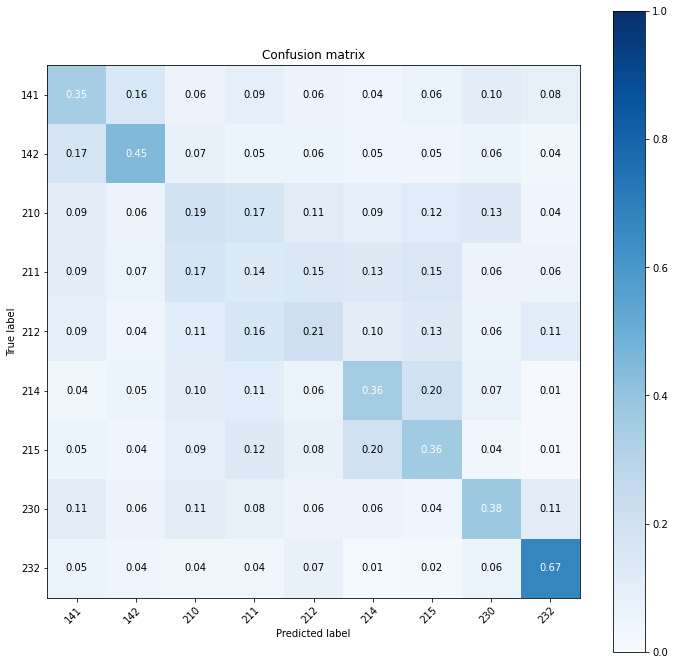

In [31]:

# # what data to use, specify here 
metadata = sounds_metadata
print('Keys: ', list(metadata.columns))
colonies = 'all'
#colonies that specified here are used to train classifer
weights = 'all'
dates = 'all'
sexes = 'all' # options:('M'), ('F'), 'all'
ages = 'all' # options: [180, np.inf], in days
ages_foster = 'all'# specifies ages of foster pups
ranks = 'all' # options: ('rank1', 'rank2', 'rank3', 'rank4', 'rank5')
ratids = 'all' # can specify indivudals here
bodylengths = 'all' # options: (0, np.inf), all # snout to tail length measured
bodylengths2 ='all' # options: (0, np.inf), all # snout to rump length measured

exclude_rats = ['213'] 
sounds_per_rat = 'all'
#'single', 'pairs', 'all'
types = 'single'

features_to_classify = ['pitch', 'wiener_entropy', 'zero_crossings', 'duration',]

classify_by = 'ratids'
group_by = None
balance = True 
cv_n_folds = 3
analyse_fosters = False
cmap = plt.cm.Blues


order = ORDER[classify_by]
#specifies order of classes and colors that plotted
color = COLOR[classify_by]
color_dict = COLOR[classify_by]



mask =  filter_sounds_metadata_extended(metadata, ratids, exclude_rats,
                                   types, colonies, weights, sexes, ages, ranks, dates,
                                   bodylengths, bodylengths2, sounds_per_rat)
mask_foster = filter_sounds_metadata_extended(metadata, [], None, types, 'all', weights,
                                              sexes, ages_foster, ranks, dates,
                                              bodylengths, bodylengths2, 'all')

if False:  # BINNING OF CLASSIFY COLUMN
    binsize = 10
    mask_index = metadata[mask].index
    metadata.loc[mask_index, classify_by] = make_bins(metadata[mask][classify_by], binsize)
if False:  # BINNING OF GROUP COLUMN
    binsize = 10 
    metadata[mask][group_by] = make_bins(metadata[mask][group_by], binsize)
    
print_info = True
clf, foster_probs, y_unique, y_unique_foster = classify(features, metadata, mask, mask_foster,
                                                        order, classify_by,  features_to_classify, group_by,
                                                        balance, cv_n_folds, False, print_info, cmap)
print('\nFeatures importances:', )
for fn, fimp in zip(features_to_classify, clf.feature_importances_):
    print('%s: %.3f' % (fn, fimp))

